# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from fc_model import Network
from PIL import Image
from os import listdir

#fc_model from http://github.com/udacity/DL_PyTorch


In [2]:
def class_to_idx(dataset):
    classes = dataset.classes
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def idx_to_class(class_to_idx):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    return idx_to_class

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms = 
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
# image_datasets = 
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders =
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(test_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [13]:
# TODO: Build and train your network
# First load in a pretrained network 
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:15<00:00, 36296975.95it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False   

#Mimic architecture of VGG16 classifier
#Remember to include dropout 
# Do I need LogSoftmax (depends on optimizer). For nLLLoss() you need it. NB Network() will not perform softmax on the output.
    
classifier = Network(25088, 102, [4096,4096],drop_p=0.3) 

model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
#Define validation function
def validation(model, dataloader, criterion ):
    
    valid_loss = 0
    accuracy = 0
    for images,labels in dataloader:
   
        #move model and data to GPU
        images, labels = images.to('cuda'), labels.to('cuda')
        model.to('cuda')

        output = model.forward(images)
        valid_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.cuda.FloatTensor).mean()
        
    return valid_loss, accuracy

In [16]:
#Train the model

#set criterion and optimizer
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
#send model to GPU
model.to('cuda')

# TODO: Train the network here
#with active_session():
epochs = 3
print_every = 10
steps = 0
running_loss = 0
acc_list = []
for e in range(epochs):
    running_loss = 0
    last_accuracy = 0
    for inputs, labels in iter(trainloader):
        steps += 1

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        #start = time.time()

        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # Forward pass, then backward pass, then update weights
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
                

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Valid Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                  "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            last_accuracy = accuracy.item()/len(validloader)
            # Make sure training is back on
            model.train()


Epoch: 1/3..  Training Loss: 1.596..  Valid Loss: 0.930..  Valid Accuracy: 0.735
Epoch: 1/3..  Training Loss: 1.448..  Valid Loss: 0.875..  Valid Accuracy: 0.750
Epoch: 1/3..  Training Loss: 1.329..  Valid Loss: 0.837..  Valid Accuracy: 0.760
Epoch: 1/3..  Training Loss: 1.342..  Valid Loss: 0.822..  Valid Accuracy: 0.763
Epoch: 1/3..  Training Loss: 1.483..  Valid Loss: 0.819..  Valid Accuracy: 0.771
Epoch: 1/3..  Training Loss: 1.393..  Valid Loss: 0.810..  Valid Accuracy: 0.768
Epoch: 1/3..  Training Loss: 1.302..  Valid Loss: 0.807..  Valid Accuracy: 0.769
Epoch: 1/3..  Training Loss: 1.276..  Valid Loss: 0.807..  Valid Accuracy: 0.772
Epoch: 1/3..  Training Loss: 1.232..  Valid Loss: 0.798..  Valid Accuracy: 0.774
Epoch: 1/3..  Training Loss: 1.246..  Valid Loss: 0.787..  Valid Accuracy: 0.779
Epoch: 2/3..  Training Loss: 0.893..  Valid Loss: 0.763..  Valid Accuracy: 0.782
Epoch: 2/3..  Training Loss: 1.188..  Valid Loss: 0.755..  Valid Accuracy: 0.779
Epoch: 2/3..  Training Loss:

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
criterion = nn.NLLLoss()
   
#Make sure network is in eval mode for inference
model.eval()

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    test_loss, accuracy = validation(model, testloader, criterion)


print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))



Test Loss: 0.715..  Test Accuracy: 0.813


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [22]:
# TODO: Save the checkpoint 
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'hidden_layers': [each.out_features for each in classifier.hidden_layers],
              'drop_p': 0.3,
              'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(),
              'criterion' : nn.NLLLoss(),
              'class_to_idx': train_data.class_to_idx,
              'class_to_name': cat_to_name,
             'epochs': epochs}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [7]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained=True)
    classifier = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'], 
                         drop_p=checkpoint['drop_p'])
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    #model.criterion = criterion(checkpoint['criterion'])
    model.optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    model.optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = (checkpoint['class_to_idx'])
    model.class_to_name = (checkpoint['class_to_name'])
    
    return model

In [8]:
model = load_checkpoint('checkpoint.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:15<00:00, 36491689.49it/s]


In [11]:
#CHECK THE RELOADED MODEL PERFORMS AS EXPECTED
criterion = nn.NLLLoss()
   
#Make sure network is in eval mode for inference
model.eval()

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    test_loss, accuracy = validation(model, testloader, criterion)


print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))



Test Loss: 0.715..  Test Accuracy: 0.813


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [9]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #Open
    im=Image.open(image)
    
    #Scale    
    min_side = 256
    width = im.size[0]
    height = im.size[1]
    if width < height:   
        im = im.resize((min_side, int(height/width * min_side)))
    else:    
        im = im.resize((int(width/height * min_side), min_side))
        
    #Crop
    crop1 = int((im.size[0]-224)/2) # top left x-coordinate
    crop2 = int((im.size[1]-224)/2) # top left y-coordinate
    crop3 = crop1 + 224 # bottom right x-coordinate
    crop4 = crop2 + 224 # bottom right y-coordinate
    im = im.crop((crop1, crop2, crop3, crop4))
    
    #convert to Numpy array with float datatype
    np_image = np.array(im, dtype = np.float64)
    
    #Normalize
    np_image = np_image/255
    np_image = (np_image - [0.485, 0.456, 0.406])/[0.229, 0.224, 0.225]
    
    
    #Transpose: 3rd dim becomes 1st, 1st becomes 2nd, 2nd becomes 3rd
    np_image = np_image.transpose((2,0,1))
    
    #Switch from numpy array to PyTorch tensor
    
    np_image = torch.from_numpy(np_image)
    
    return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [10]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

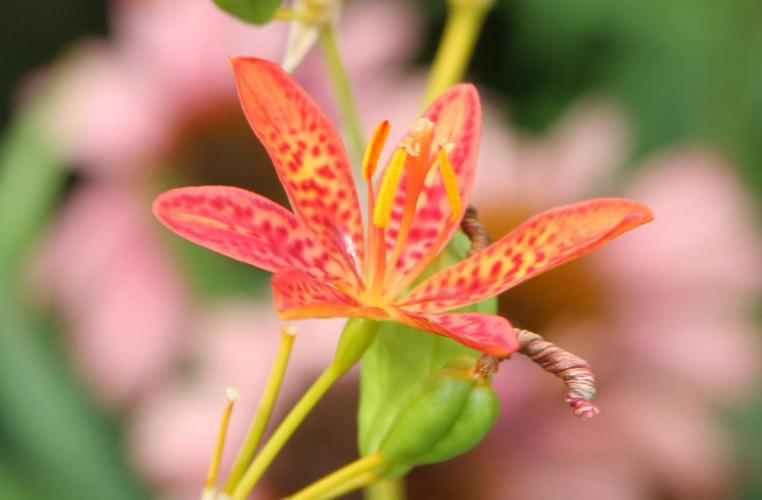

In [16]:
#Open and display an image
filepath = 'flowers/train/102/image_08007.jpg'
im=Image.open(filepath)
im

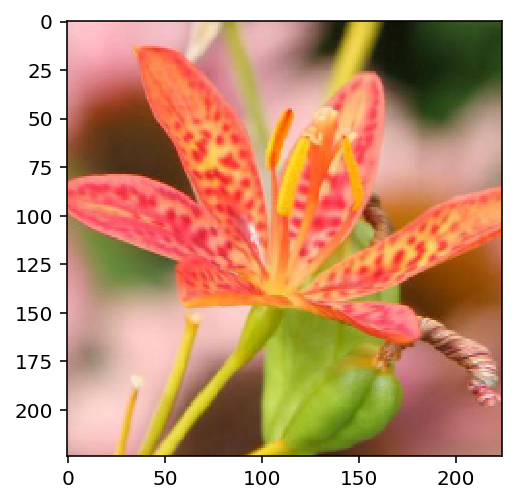

In [17]:
#check that after running through imshow(process_image()) returns the original (cropped) image
filepath = 'flowers/train/102/image_08007.jpg'
z = process_image(filepath)
imshow(z)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [11]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    #process image
    im = process_image(image_path)
    #move model and data to GPU
    im = im.to('cuda')
    model.to('cuda')
    
    #for passing single image, need to add dimension o
    im.unsqueeze_(0)
    #cast to float tensor
    im = im.float()
    #Make sure network is in eval mode for inference
    model.eval()

    # Turn off gradients for inference, saves memory and computations
    with torch.no_grad():
        #do forward pass
        output = model.forward(im)
    
    ps = torch.exp(output)
    return ps.topk(topk)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

desert-rose
[0.8233869075775146, 0.14500072598457336, 0.008661065250635147, 0.0044378009624779224, 0.00379967107437551] ['sword lily', 'desert-rose', 'hippeastrum', 'bromelia', 'azalea']


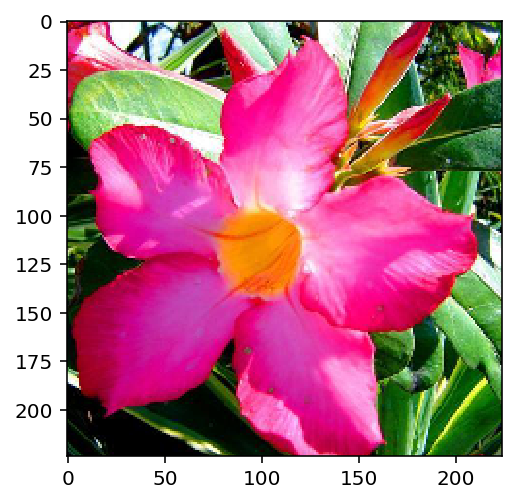

In [26]:
# TODO: Display an image along with the top 5 classes
# Display image and name
filepath = 'flowers/test/85/image_04797.jpg'
imshow(process_image(filepath))
print(cat_to_name['85'])
#Predict topk
top_k = predict(filepath, model, topk=5)
#obtain probabilities from top_k

probs = np.array(top_k[0])
idx = np.array(top_k[1])
#move to a list
probs = probs[0].tolist()
idx=idx[0].tolist()
#create class_to_idx and idx_to_class dictionaries
class_to_idx = model.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
#create empty list names
names=[]
for i in range(len(idx)):
    names.append(cat_to_name[idx_to_class[idx[i]]])

print(probs,names)


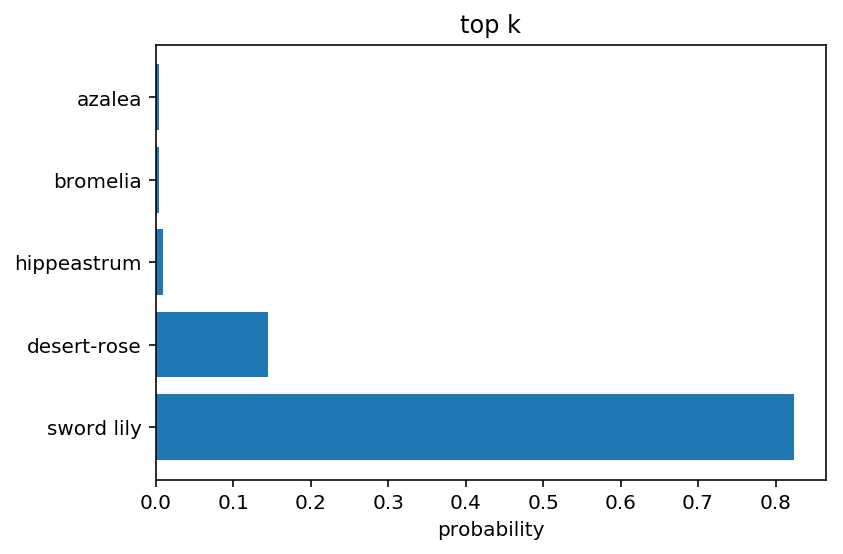

In [21]:
#Plot probabilities on a bar chart
categories = names
y_pos = np.arange(len(categories))
probabilities = probs
plt.barh(y_pos, probabilities)
plt.yticks(y_pos, categories)
plt.xlabel('probability')
plt.title('top k')
 
plt.show()

desert-rose


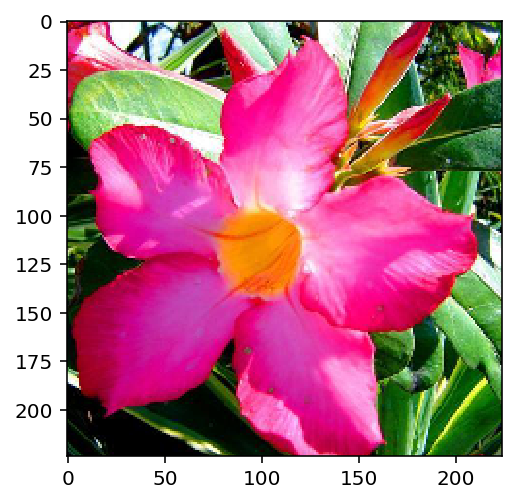

In [21]:
#The above test gives a surprising result. Break the process down to check.

filepath = 'flowers/test/85/image_04797.jpg'
imshow(process_image(filepath))
print(cat_to_name['85'])

#MANUAL CHECKS
#From cat to name (see out[22]) Cat 85 is desert-rose. So name is being retrieved correctly.
#From folder flowers/test/85/image_04797.jpg is the image the expected one?


In [23]:
#display output of predict function
#Predict topk
top_k = predict(filepath, model, topk=5)
top_k

(tensor([[ 0.9728,  0.0154,  0.0066,  0.0017,  0.0014]], device='cuda:0'),
 tensor([[ 40,  86,  93,  12,  84]], device='cuda:0'))

In [ ]:
#The highest probability corresponds to idx 40.
#MANUAL CHECK
#From class_to_idx, idx 40 corresponds to class 43 (see Out[25]). Class 43 is sword Lily (from cat_to_name)
#From class_to_idx, idx 86 correpsonds to class 85 (see Out[25]). Class 85 is Desert-Rose (the correct answer!)
#So, the results of the predict function are being reported correctly. 
#This would indicate either the model genuinely thinks a desert rose is a sword lily. 
#OR there is a problem with the predict function which is reporting 1dx has the highest probability when it should be idx 86.


In [27]:
#Following retraining of the model the output is slightly different (see cell 26) howevr sword-lily is still the favourite
#followed by desert-rose. It has been confirmed that the result is the same whether the predict() function is run immediately
#immediately after training or following saving and reloading. Hence the CHECKPOINT LOADS CORRECTLY.

In [43]:
#It is still possible that the predict function is reporting the model results incorrectly. To test this I need to try
#passing a larger number of individual images
#create a test set of filenames as a list. use 1 image from each folder. img index is 0 for the first image 1 for second etc.
def test_set(img_idx):
    img_idx = img_idx
    filenames=[]
    for folder in range(1,103):
        filename = listdir('flowers/test/' + str(folder))[img_idx]
        filenames.append('flowers/test/' + str(folder) + '/' + filename)
    return filenames


#create a function which uses predict to print pairs of flower names and predicted flower names
def name_prediction(filepath, folder):

    filepath = filepath
    #get flower name directly from folder name
    folder=str(folder)
    name = str(cat_to_name[folder])
    #Predict topk
    top_k = predict(filepath, model, topk=1)
    #obtain probabilities from top_k

    probs = np.array(top_k[0])
    idx = np.array(top_k[1])
    #move to a list
    probs = probs[0].tolist()
    idx=idx[0].tolist()
    #create class_to_idx and idx_to_class dictionaries
    class_to_idx = model.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    #create empty list names
    prediction=cat_to_name[idx_to_class[idx[0]]]
    #for i in range(len(idx)):
        #predictions.append(cat_to_name[idx_to_class[idx[i]]])
    if name == prediction:
        match = 1
    else:
        match = 0
        
    return name, prediction, match   

#create testset containing all of the images in the test folder
def test_all():

    filenames=[]
    for folder in range(1,103):
        filelist = listdir('flowers/test/' + str(folder))
        for file in filelist:
            filenames.append([file, folder])
    return filenames


In [44]:
#create testsets
testset1=test_set(0)
testset2=test_set(1)
#testset3=test_set(2)


In [47]:
fullset = test_all()
len(fullset)
print(fullset[:25])

[['image_06764.jpg', 1], ['image_06754.jpg', 1], ['image_06760.jpg', 1], ['image_06743.jpg', 1], ['image_06752.jpg', 1], ['image_05109.jpg', 2], ['image_05133.jpg', 2], ['image_05100.jpg', 2], ['image_05107.jpg', 2], ['image_05125.jpg', 2], ['image_06634.jpg', 3], ['image_06641.jpg', 3], ['image_05658.jpg', 4], ['image_05636.jpg', 4], ['image_05678.jpg', 4], ['image_05653.jpg', 4], ['image_05640.jpg', 4], ['image_05637.jpg', 4], ['image_05186.jpg', 5], ['image_05169.jpg', 5], ['image_05166.jpg', 5], ['image_05159.jpg', 5], ['image_07199.jpg', 6], ['image_08106.jpg', 6], ['image_07182.jpg', 6]]


In [50]:
#test for the full set of 819 test images and sum match to give a total of correct matches
total_matches = 0
for i in range(len(fullset)):
    image_path = 'flowers/test/' + str(fullset[i][1]) + '/' + fullset[i][0]
    name, prediction, match = name_prediction(image_path, fullset[i][1])
    #print(name, prediction, match)
    total_matches += match
    accuracy = total_matches/len(fullset)
print('total matches: {:.3f}..'.format(total_matches), 'accuracy: {:.3f}..'.format(accuracy))

total matches: 660.000.. accuracy: 0.806..


In [ ]:
#this is not exactly the same as the accuracy calculated using testloader and validation() function, but it is very close
#and above 80% accuracy. The model is therefore  considered to perform satisfactorily.